In [1]:
import pandas as pd
import numpy as np
from math import log10
import sys
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

Import weather_scrape.py and electricity_scrape.py files containing functions to scrape data

In [5]:
from weather_scrape import *
from electricity_scrape import *

Run function "weather_dl_range" to download weather data for specified time range

In [4]:
# weather params
city = 'yyc'
station_ID = '50430'
startyear = "2020"
endyear = "2021"
#get raw data into pd dataframe
weather_df  = weather_dl_range(startyear, endyear, city, station_ID)

data for year 2020 downloaded
sleep for 8 seconds
data for year 2021 downloaded
sleep for 5 seconds


C:\conda\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Run function "aeso_download_range" to scrape electricity daily average pool prices for time range

In [6]:
#electricity params
tablename = 'DailyAveragePoolPrice'
startdate = '2024-01-01'
enddate = '2024-01-10'
dateformat = '%Y-%m-%d'
contenttype = 'html'
#get table of downloaded data, sort by date
util_prices = aeso_download_range(tablename, contenttype, startdate, enddate, dateformat).sort_values(by='$/MWh_Date').reset_index()


date range <= 30 days, downloading
converted date string from 2024-01-01 00:00:00 to datetime value 01012024
converted date string from 2024-01-10 00:00:00 to datetime value 01102024
download url generated: http://ets.aeso.ca/ets_web/ip/Market/Reports/DailyAveragePoolPriceReportServlet?beginDate=01012024&endDate=01102024&contentType=html


In [7]:
util_prices

,index,$/MWh_Date,Daily_Average,Daily_On Peak Average,Daily_Off Peak Average,30Ravg_Average,30Ravg_On Peak Average,30Ravg_Off Peak Average
0,9,2000-01-01,34.68,38.47,27.10,50.66,58.32,35.34
1,8,2000-01-02,84.83,98.95,56.59,51.07,58.96,35.27
2,7,2000-01-03,63.80,51.33,88.75,51.00,58.09,36.82
3,6,2000-01-04,40.75,42.26,37.75,50.75,57.86,36.51
4,5,2000-01-05,66.05,69.82,58.51,49.70,56.17,36.76
5,4,2000-01-06,88.86,112.52,41.54,48.90,55.84,35.02
6,3,2000-01-07,171.70,217.46,80.17,50.47,58.42,34.56
7,2,2000-01-08,75.53,64.63,97.34,51.63,59.16,36.58
8,1,2000-01-09,39.26,38.70,40.37,51.82,59.21,37.05
9,0,2000-01-10,116.03,148.01,52.09,54.05,62.35,37.45


Join weather data and electricity price data together for analysis

In [6]:
#join tables together
df_join = util_prices.merge(weather_df, how = 'left', left_on = '$/MWh_Date', right_on = 'Date/Time')

Pick Daily_Average as the price to analyze (predictor label), and convert to kwh for standard consumer units
Define columns used for prediction label, features and timestamp

In [7]:
df_join['Avg_Price_kwh'] = df_join['Daily_Average'] / 1000
df_join = df_join.rename(columns = {'$/MWh_Date':'Date'})

In [8]:
#define label and features
labels = ['Avg_Price_kwh']
features = ['Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
            'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
            'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)',
            'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']
ts_col = ['Date']

In [42]:
#look at some summary stats on the data
df_join.describe(include='all')

<ipython-input-42-945ca3f0709a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_join.describe(include='all')
<ipython-input-42-945ca3f0709a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_join.describe(include='all')


,index,Date,Daily_Average,Daily_On Peak Average,Daily_Off Peak Average,30Ravg_Average,30Ravg_On Peak Average,30Ravg_Off Peak Average,Date/Time,Year,...,Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),Avg_Price_kwh
count,428.000000,428,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428,428.000000,...,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
unique,NaN,428,NaN,NaN,NaN,NaN,NaN,NaN,428,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2020-04-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-13 00:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-01 00:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2021-03-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-03 00:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,213.500000,NaN,55.628061,66.374439,34.393551,53.089136,63.011379,33.252757,NaN,2020.144860,...,3.204322,14.967874,0.172196,0.964953,0.476168,1.369159,2.850467,19.000000,39.647196,0.055628
std,123.697211,NaN,76.592917,104.926979,25.140328,32.945763,44.174512,11.404433,NaN,0.352371,...,11.266406,11.009951,0.743747,4.707270,1.564744,4.835581,5.005484,13.442392,21.320776,0.076593
min,0.000000,NaN,13.140000,13.020000,4.360000,25.950000,27.970000,20.850000,NaN,2020.000000,...,-29.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013140
25%,106.750000,NaN,30.720000,32.327500,27.137500,35.180000,39.220000,25.845000,NaN,2020.000000,...,-3.725000,4.775000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,33.000000,0.030720


In [49]:
#view the first 10 rows of data
df_join.loc[range(0,10)]

,index,Date,Daily_Average,Daily_On Peak Average,Daily_Off Peak Average,30Ravg_Average,30Ravg_On Peak Average,30Ravg_Off Peak Average,Date/Time,Year,...,Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),Avg_Price_kwh
0,30,2020-01-01,33.51,35.03,30.46,43.56,48.90,32.88,2020-01-01,2020,...,-0.3,18.3,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.03351
1,29,2020-01-02,32.92,35.20,28.35,43.61,48.97,32.89,2020-01-02,2020,...,-3.0,21.0,0.0,0.0,2.0,1.8,3.0,34.0,48.0,0.03292
2,28,2020-01-03,34.60,35.30,33.22,43.66,48.98,33.03,2020-01-03,2020,...,-0.1,18.1,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.03460
3,27,2020-01-04,31.52,33.97,26.62,43.11,48.42,32.50,2020-01-04,2020,...,2.8,15.2,0.0,0.0,1.0,0.5,2.0,35.0,67.0,0.03152
4,26,2020-01-05,32.21,34.54,27.54,42.82,48.15,32.18,2020-01-05,2020,...,-3.9,21.9,0.0,0.0,0.0,0.0,3.0,25.0,52.0,0.03221
5,25,2020-01-06,65.48,81.43,33.57,42.77,48.03,32.24,2020-01-06,2020,...,-4.2,22.2,0.0,0.0,0.0,0.0,3.0,35.0,74.0,0.06548
6,24,2020-01-07,40.34,38.23,44.55,42.30,47.17,32.58,2020-01-07,2020,...,-9.3,27.3,0.0,0.0,0.0,0.0,3.0,12.0,32.0,0.04034
7,23,2020-01-08,42.94,49.77,29.26,41.71,46.30,32.53,2020-01-08,2020,...,-10.7,28.7,0.0,0.0,0.0,0.0,4.0,35.0,52.0,0.04294
8,22,2020-01-09,47.94,54.27,35.28,41.45,45.84,32.68,2020-01-09,2020,...,-15.7,33.7,0.0,0.0,0.2,0.2,7.0,35.0,35.0,0.04794
9,21,2020-01-10,33.69,33.64,33.79,40.66,44.60,32.78,2020-01-10,2020,...,-13.6,31.6,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.03369


Subset dataframe columns to just labels and features, generate a crossplot of all features against the label column

<IPython.core.display.Javascript object>


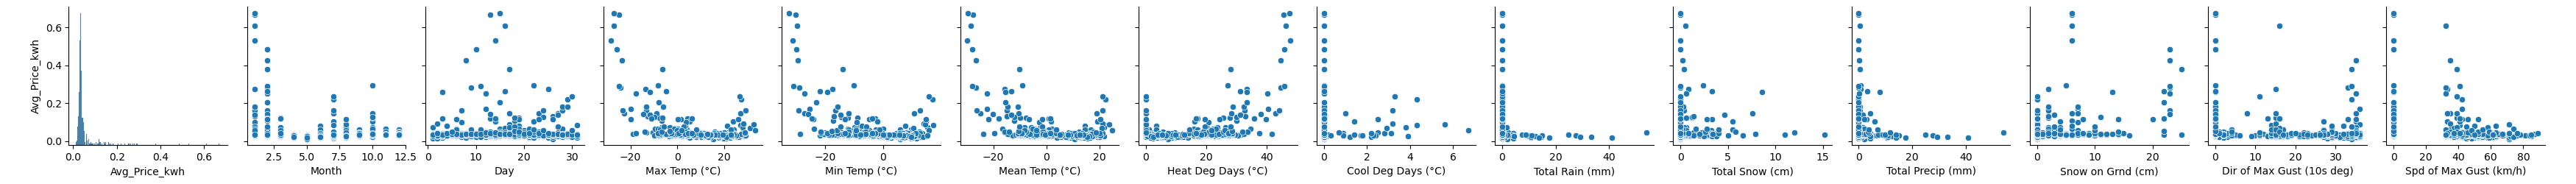

In [39]:
df_mod = df_join[labels + features]

sns.pairplot(df_mod, y_vars = labels[0], x_vars = df_mod.columns.values)
plt.show()


Looks like there might be outliers, try removing outliers and re evaluate feature vs label on a log10 scale

<IPython.core.display.Javascript object>


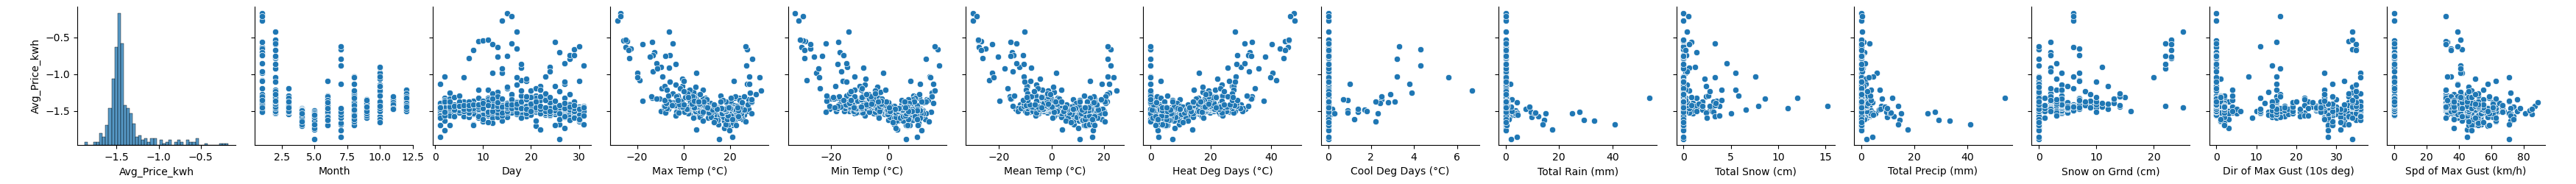

In [40]:
#function to remove outliers based on IQR range, use interpolated value to replace outliers
def outlier_rm(x, iqr_range, log_shift):
    if log_shift is True:
        x = x.apply(lambda x: log10(x))
    out1 = [float('nan')] * len(x)
    detr = [0] + [j-i for i, j in zip(x[:-1], x[1:])]
    iqr_x = iqr_range*np.subtract(*np.percentile(detr, [75,25]))
    ix = [abs(i) for i in detr] > iqr_x
    ix = ix.tolist()
    out1 = ['outlier' if i is True else 'not_outlier' for i in ix]   
    x_out = [x[i] if ix[i] is False else float('nan') for i in range(0,len(x))]
    x_outpd = pd.Series(x_out)
    output = x_outpd.interpolate().tolist()
    output = [10**x for x in output]
    return output

#apply function to label column, in this case Avg Price kwh, also do log10 transform
df_mod_outlier_rm = copy(df_mod)
df_mod_outlier_rm[labels[0]] = outlier_rm(df_mod_outlier_rm[labels[0]], iqr_range = 2, log_shift = True)
df_mod_outlier_rm[labels[0]] = df_mod_outlier_rm[labels[0]].apply(lambda x: log10(x))
sns.pairplot(df_mod_outlier_rm, y_vars = labels[0], x_vars = df_mod_outlier_rm.columns.values)
plt.show()

In [50]:
import statsmodels.api as sm

In [86]:
selected_features = [features[n] for n in range(0,3)]
df_mod_outlier_rm[selected_features] = df_mod_outlier_rm[selected_features].apply(lambda x: x.astype(float))
X = np.array(df_mod_outlier_rm[selected_features])
y = np.array(df_mod_outlier_rm[labels[0]])
X = sm.add_constant(X)
mod_ols = sm.OLS(y , X)
results = mod_ols.fit()
print(results.summary())
print('selected features are:')
print(selected_features)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     56.58
Date:                Wed, 03 Mar 2021   Prob (F-statistic):           8.87e-31
Time:                        20:49:38   Log-Likelihood:                 78.614
No. Observations:                 428   AIC:                            -149.2
Df Residuals:                     424   BIC:                            -133.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3467      0.025    -53.802      0.0

In [84]:
X.shape

(428, 4)

In [85]:
y_pred = mod_ols.predict(X)


ValueError: shapes (428,4) and (428,4) not aligned: 4 (dim 1) != 428 (dim 0)